In [ ]:
#|default_exp examples.text.multilabel_classification


In [ ]:
#| nbflags skip_exec


In [ ]:
#|hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Multi-label classification

> This is an example of how to use blurr for multilabel classification tasks using both the mid and high level Blurr API

In [ ]:
#|export
import os

import datasets
from transformers import *
from fastai.text.all import *
from fastai.callback.hook import _print_shapes


from blurr.text.data.core import *
from blurr.text.modeling.core import *
from blurr.text.utils import *
from blurr.utils import *

logging.set_verbosity_error()


In [ ]:
#| echo: false
import pdb

from fastcore.test import *
from nbdev.showdoc import show_doc

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Here's what we're running with ...\n")
print_versions("torch fastai transformers")


Here's what we're running with ...

torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.16.2


In [ ]:
#|cuda
#|hide
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


Let's start by building our `DataBlock`

In [ ]:
raw_datasets = datasets.load_dataset("civil_comments")
raw_datasets


Using custom data configuration default
Reusing dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['identity_attack', 'insult', 'obscene', 'severe_toxicity', 'sexual_explicit', 'text', 'threat', 'toxicity'],
        num_rows: 1804874
    })
    validation: Dataset({
        features: ['identity_attack', 'insult', 'obscene', 'severe_toxicity', 'sexual_explicit', 'text', 'threat', 'toxicity'],
        num_rows: 97320
    })
    test: Dataset({
        features: ['identity_attack', 'insult', 'obscene', 'severe_toxicity', 'sexual_explicit', 'text', 'threat', 'toxicity'],
        num_rows: 97320
    })
})

In [ ]:
# --- Option 1: Experimental subset (using 10k training examples) ---
raw_train_df = raw_datasets["train"].shuffle(seed=42).select(range(10000)).to_pandas()
raw_valid_df = raw_datasets["validation"].shuffle(seed=42).select(range(2000)).to_pandas()

# --- Option 2: Full dataset (using the predefined training and validation sets) ---
# raw_train_df = pd.DataFrame(raw_datasets['train'], columns=list(raw_datasets['train'].features.keys()))
# raw_valid_df = pd.DataFrame(raw_datasets['validation'], columns=list(raw_datasets['validation'].features.keys()))

raw_train_df["is_valid"] = False
raw_valid_df["is_valid"] = True

toxic_df = pd.concat([raw_train_df, raw_valid_df])
print(len(toxic_df))


Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-8b5168c3a65cf5ce.arrow
Loading cached shuffled indices for dataset at /home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab/cache-0ee0733b0b10f4a7.arrow


12000


In [ ]:
toxic_df.head()


,identity_attack,insult,obscene,severe_toxicity,sexual_explicit,text,threat,toxicity,is_valid
0,0.0,0.200000,0.300000,0.000000,0.0,Socialists? What the hell does that have to do with climate science? Good grief.,0.0,0.300000,False
1,0.0,0.794118,0.088235,0.029412,0.0,"And I always thought that Eric Trump was the dumbest son. Sorry, Eric!",0.0,0.808824,False
2,0.0,0.000000,0.000000,0.000000,0.0,"I’m disappointed there’s no report from CB on the transportation committee meeting today and the discussion about eminent domain. It centered on the Bloodbank and the HART CEO’s lack of knowledge that HART filed a lawsuit against the Bloodbank the day before Councilmember Anderson asked about the status of that property (May 16).\n\nTo sum it up, Murthy nor the board knew that HART was suing the Bloodbank. It’s troubling that a lawsuit can be started without explicit authority from the CEO and board.\n\nThe other part of the discussion that was disappointing was the deputy corporation co...",0.0,0.000000,False
3,0.0,0.166667,0.000000,0.000000,0.0,"Nothing like subsidizing a country that is threatening trade barriers with us.\n\nBut again we are talking about Kathleen and her cronies. I do love electric cars, but in a province that still allows gas blowing leaf blowers, classic cars that admit 100 times what normal ICE emit, two cycle outboard marine engines, idiotic two cycle jet skis and snowmobiles....and the list goes on and on. If she wants real easy environmental solutions get rid of these dinosaur beasts. Its easy, politically tough in certain jurisdictions, and quit pandering to the US car companies and wealthy individuals w...",0.0,0.166667,False
4,0.0,0.000000,0.000000,0.000000,0.0,"The only way to save the rhino is to legalize the trade in horn and allow the farmers to breed the animals and make a profit. Nobody is seriously thinking that legal trade will satisfy the demand or stop the poaching entirely, but farmers will have enough money to jack up security. Rhino numbers will undoubtedly increase, and isn't that the primary consideration? One thing we know: the ban is a disaster. This entire poaching catastrophe has taken place with the BAN INTACT. We can't be entirely sure what will work, but we know without a doubt what is not working: the BAN. Kill the ban or ki...",0.0,0.000000,False


In [ ]:
lbl_cols = ["identity_attack", "insult", "obscene", "toxicity", "severe_toxicity", "sexual_explicit", "threat"]
lbl_cols


['identity_attack',
 'insult',
 'obscene',
 'toxicity',
 'severe_toxicity',
 'sexual_explicit',
 'threat']

In [ ]:
toxic_df = toxic_df.round({col: 0 for col in lbl_cols})
toxic_df = toxic_df.convert_dtypes()

toxic_df.head()


,identity_attack,insult,obscene,severe_toxicity,sexual_explicit,text,threat,toxicity,is_valid
0,0,0,0,0,0,Socialists? What the hell does that have to do with climate science? Good grief.,0,0,False
1,0,1,0,0,0,"And I always thought that Eric Trump was the dumbest son. Sorry, Eric!",0,1,False
2,0,0,0,0,0,"I’m disappointed there’s no report from CB on the transportation committee meeting today and the discussion about eminent domain. It centered on the Bloodbank and the HART CEO’s lack of knowledge that HART filed a lawsuit against the Bloodbank the day before Councilmember Anderson asked about the status of that property (May 16). To sum it up, Murthy nor the board knew that HART was suing the Bloodbank. It’s troubling that a lawsuit can be started without explicit authority from the CEO and board. The other part of the discussion that was disappointing was the deputy corporation counse...",0,0,False
3,0,0,0,0,0,"Nothing like subsidizing a country that is threatening trade barriers with us. But again we are talking about Kathleen and her cronies. I do love electric cars, but in a province that still allows gas blowing leaf blowers, classic cars that admit 100 times what normal ICE emit, two cycle outboard marine engines, idiotic two cycle jet skis and snowmobiles....and the list goes on and on. If she wants real easy environmental solutions get rid of these dinosaur beasts. Its easy, politically tough in certain jurisdictions, and quit pandering to the US car companies and wealthy individuals who...",0,0,False
4,0,0,0,0,0,"The only way to save the rhino is to legalize the trade in horn and allow the farmers to breed the animals and make a profit. Nobody is seriously thinking that legal trade will satisfy the demand or stop the poaching entirely, but farmers will have enough money to jack up security. Rhino numbers will undoubtedly increase, and isn't that the primary consideration? One thing we know: the ban is a disaster. This entire poaching catastrophe has taken place with the BAN INTACT. We can't be entirely sure what will work, but we know without a doubt what is not working: the BAN. Kill the ban or ki...",0,0,False


## Mid-level API

### Step 1: Build our Hugging Face objects

For our huggingface model, let's used the distilled version of RoBERTa. This should allow us to train the model on bigger mini-batches without much performance loss.  Even on my 1080Ti, I should be able to train all the parameters (which isn't possible with the `roberta-base` model)

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))


roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


Note how we have to configure the `num_labels` to the number of labels we are predicting. Given that our labels are already encoded, we use a `MultiCategoryBlock` with encoded=True and vocab equal to the columns with our 1's and 0's.

### Step 2: Build our `DataLoaders`

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True, vocab=lbl_cols))
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader(lbl_cols), splitter=ColSplitter())


In [ ]:
dls = dblock.dataloaders(toxic_df, bs=4, val_bs=8)


In [ ]:
b = dls.one_batch()
len(b), b[0]["input_ids"].shape, b[1].shape


(2, torch.Size([4, 512]), torch.Size([4, 7]))

### Step 3: Build our `Learner`

With our DataLoaders built, we can now build our `Learner` and train.  We'll use mixed precision so we can train with bigger batches

In [ ]:
model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=BCEWithLogitsLossFlat(),  # PreCalculatedBCELoss()
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter,
).to_fp16()

learn.loss_func.thresh = 0.15
learn.freeze()


In [ ]:
learn.summary()


In [ ]:
preds = model(b[0])
preds.logits.shape, preds


(torch.Size([4, 7]),
 SequenceClassifierOutput(loss=TensorMultiCategory(0.6522, device='cuda:1', grad_fn=<AliasBackward0>), logits=tensor([[-0.3090,  0.0359, -0.1667, -0.0387, -0.3063, -0.0053,  0.0813],
         [-0.2999,  0.0705, -0.1847, -0.0136, -0.3005,  0.0097,  0.0636],
         [-0.2754,  0.0481, -0.1672, -0.0302, -0.2681,  0.0213,  0.0820],
         [-0.2759,  0.0567, -0.1639, -0.0284, -0.2742,  0.0129,  0.1228]],
        device='cuda:1', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None))

### Step 4: Train

SuggestedLRs(valley=0.0003981071640737355)

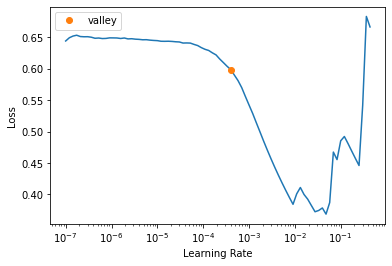

In [ ]:
learn.lr_find()


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.089716,0.064052,0.984928,01:10


In [ ]:
learn.show_results(learner=learn, max_n=2)


,text,target,prediction
0,"Richard Ellmyer - I think most sane, patriotic Americans hear and agree with your total exasperation at this lawless, ridiculous situation. However, while I agree I am very disturbed at the approach by the FBI SACs in Nevada and Portland, I think you are missing who is responsible here. On January 4, the White House made a public announcement that this terrorist takeover of U.S. Federal Government land and buildings was ""ultimately a local law enforcement matter."" Then after that, ""Obama administration leaders"" told Reuters that the Obama administration had ""ordered"" federal law enforcement not to have a ""conflict"" with these Sovereign Citizen terrorists in Oregon. So while there is plenty of blame to go around, I think the focus needs to be on the person who is actually making the REAL decisions here, and it is not ultimately FBI Portland SAC. I urge Oregonians to contact the White House and also presidential candidates and DEMAND a restoral of the rule of law to this anarchic situation. More children, more citizens are put at risk, and history has shown the failure to act in Nevada in 2014 ultimately cost the lives of other Americans in Las Vegas down the road from such terrorist supporters. It is time our leadership spends time doing THEIR JOB, not playing political games with media.",[],[]
1,"@Rick Tubania: You know Rick, technically there's not much of a difference between an Independent Contractor and an Employee and the only things really are the lack of health insurance and benefits. They both do work for the companies they serve. You're just trying to justify his actions because he's your buddy and we seem to be picking on him. LOL! It's still disingenuous and an abuse of vacation time to regularly take vacation at around the same time of the month or quarter from his job as Mayor that Caldwell himself declares that he's doing 24/7 on numerous occasions because he loves the job. IF he loves the job as Mayor so much, why does he need to do other work as an Independent Contractor during time that he would normally spend being the Mayor? Bottom line is Caldwell needs to be replaced as Mayor because the public can't trust what he says. I remember he told the legislature that if they extended the GET 5 years, he would have enough funds to finish rail. Wrong! LOL!!",[],[]


In [ ]:
learn.unfreeze()


In [ ]:
learn.fit_one_cycle(1, lr_max=slice(1e-8, 1e-4))


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.064716,0.063631,0.984928,02:18


In [ ]:
learn.show_results(learner=learn, max_n=2)


,text,target,prediction
0,"Richard Ellmyer - I think most sane, patriotic Americans hear and agree with your total exasperation at this lawless, ridiculous situation. However, while I agree I am very disturbed at the approach by the FBI SACs in Nevada and Portland, I think you are missing who is responsible here. On January 4, the White House made a public announcement that this terrorist takeover of U.S. Federal Government land and buildings was ""ultimately a local law enforcement matter."" Then after that, ""Obama administration leaders"" told Reuters that the Obama administration had ""ordered"" federal law enforcement not to have a ""conflict"" with these Sovereign Citizen terrorists in Oregon. So while there is plenty of blame to go around, I think the focus needs to be on the person who is actually making the REAL decisions here, and it is not ultimately FBI Portland SAC. I urge Oregonians to contact the White House and also presidential candidates and DEMAND a restoral of the rule of law to this anarchic situation. More children, more citizens are put at risk, and history has shown the failure to act in Nevada in 2014 ultimately cost the lives of other Americans in Las Vegas down the road from such terrorist supporters. It is time our leadership spends time doing THEIR JOB, not playing political games with media.",[],[]
1,"""But local economist Paul Brewbaker said the monetary savings of abandoning the project doesn’t take into account how such a move would derail Honolulu’s efforts to achieve higher urban density and improved urban mobility, and would further discourage companies from investing in Hawaii""\n\nAgain, rail was first touted for traffic decongestion, then for affordable housing, but it's really for TOD - Transit Oriented Development - for corporations to develop in Hawaii. It may sound okay from a business standpoint but Oahu is a small island. \n\nWhat about the small private mom-and-pop property owners along the Honolulu Rail Corridor? Will the city/state abuse its powers of eminent domain to pave the way for bigger private corporate development? When will the public know about this little secret of Honolulu Rail?\n\nThe Rail powers-that-be acted intransigently to railroad this project. They grossly UNDER-estimated the projected costs, KNOWING they could blackmail Oahu into this present stage.",[],[]


In [ ]:
learn.loss_func.thresh = 0.02


In [ ]:
comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.blurr_predict(comment)


[{'labels': ['insult', 'toxicity'],
  'scores': [0.04288223758339882, 0.056340090930461884],
  'class_indices': [0, 1, 0, 1, 0, 0, 0],
  'class_labels': ['identity_attack', 'insult', 'obscene', 'toxicity', 'severe_toxicity', 'sexual_explicit', 'threat'],
  'probs': [0.004133968148380518,
   0.04288223758339882,
   0.004117917735129595,
   0.056340090930461884,
   2.225281377832289e-06,
   0.0007947254925966263,
   0.0011740821646526456]}]

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True)
preds.shape, targs.shape, losses.shape


(torch.Size([2000, 7]), torch.Size([2000, 7]), torch.Size([2000]))

## High-level API

With the high-level API, we can create our DataBlock, DataLoaders, and Blearner in one line of code

In [ ]:
#|hide
try:
    del learn
    torch.cuda.empty_cache()
except:
    pass


### Step 1: Build our Hugging Face objects

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))


roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


### Step 2: Configure our `BlearnerForSequenceClassification`

In [ ]:
learn = BlearnerForSequenceClassification.from_data(
    toxic_df, pretrained_model_name, text_attr="text", label_attr=lbl_cols, dl_kwargs={"bs": 4}
)

learn.loss_func.thresh = 0.1


### Step 3: Train

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-2)


epoch,train_loss,valid_loss,f1_score,accuracy_multi,time
0,0.079307,0.063679,0.000000,0.984928,01:03


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
learn.show_results(learner=learn, max_n=2)


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,text,target,prediction
0,"Richard Ellmyer - I think most sane, patriotic Americans hear and agree with your total exasperation at this lawless, ridiculous situation. However, while I agree I am very disturbed at the approach by the FBI SACs in Nevada and Portland, I think you are missing who is responsible here. On January 4, the White House made a public announcement that this terrorist takeover of U.S. Federal Government land and buildings was ""ultimately a local law enforcement matter."" Then after that, ""Obama administration leaders"" told Reuters that the Obama administration had ""ordered"" federal law enforcement not to have a ""conflict"" with these Sovereign Citizen terrorists in Oregon. So while there is plenty of blame to go around, I think the focus needs to be on the person who is actually making the REAL decisions here, and it is not ultimately FBI Portland SAC. I urge Oregonians to contact the White House and also presidential candidates and DEMAND a restoral of the rule of law to this anarchic situation. More children, more citizens are put at risk, and history has shown the failure to act in Nevada in 2014 ultimately cost the lives of other Americans in Las Vegas down the road from such terrorist supporters. It is time our leadership spends time doing THEIR JOB, not playing political games with media.",[],[]
1,"Your comment is ridiculous. Should I protest at a hospital because I want less military spending? Disrespecting a symbol of why you are free to protest/have dumb thoughts on a subject/are safe does not make sense. The Flag and Anthem are not symbols you disrespect just as I would never burn a cross, Star of David or Koran. Those are symbols and things held dear to people. If its fine to dis the flag, what if they decided to burn a cross?\nThe whole BLM movement is a racist farce in America. Stats show there IS NOT any genocide of black men or anyone by cops in America. There are very, very few black men shot by cops in questionable circumstances in America. Ferguson is one example. The cop was almost killed and Mike Brown deserved what he got. The false narrative was that he was knelt down and shot in the back of the head by a racist cop. Sorry, didn't happen.What does happen is thousands and thousands of young black men murder one another and BLM ignores that horrifying stat","[insult, toxicity]",[]


In [ ]:
learn.loss_func.thresh = 0.01

comment = """
Those damned affluent white people should only eat their own food, like cod cakes and boiled potatoes. 
No enchiladas for them!
"""
learn.predict(comment)


[{'labels': ['insult', 'toxicity'],
  'scores': [0.045652199536561966, 0.060720182955265045],
  'class_indices': [0, 1, 0, 1, 0, 0, 0],
  'class_labels': ['identity_attack', 'insult', 'obscene', 'toxicity', 'severe_toxicity', 'sexual_explicit', 'threat'],
  'probs': [0.003910946659743786,
   0.045652199536561966,
   0.003097661305218935,
   0.060720182955265045,
   1.0245050816592993e-06,
   0.00038578492240048945,
   0.0010632844641804695]}]

In [ ]:
# if using the precalculated loss, you need to set `with_loss=False`
preds, targs = learn.get_preds(with_loss=False)
preds.shape, targs.shape


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


(torch.Size([2000, 7]), torch.Size([2000, 7]))

## Low-level API

### Step 1: Build our Hugging Face objects

In [ ]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilroberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(lbl_cols)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

print(hf_arch)
print(type(hf_config))
print(type(hf_tokenizer))
print(type(hf_model))


roberta
<class 'transformers.models.roberta.configuration_roberta.RobertaConfig'>
<class 'transformers.models.roberta.tokenization_roberta_fast.RobertaTokenizerFast'>
<class 'transformers.models.roberta.modeling_roberta.RobertaForSequenceClassification'>


### Step 2: Prepare your dataset

We'll create a `labels` column that includes the OHE labels for each example. The raw values come in the form of probabilities ranging from 0. to 1., so we simply round those >= .51 to 1.0, else set it to 0. for our purposes here

In [ ]:
raw_datasets = datasets.load_dataset("civil_comments", split=["train[:1000]", "validation[:500]"])
raw_datasets


Using custom data configuration default
Reusing dataset civil_comments (/home/wgilliam/.cache/huggingface/datasets/civil_comments/default/0.9.0/e7a3aacd2ab7d135fa958e7209d10b1fa03807d44c486e3c34897aa08ea8ffab)


  0%|          | 0/2 [00:00<?, ?it/s]

[Dataset({
     features: ['identity_attack', 'insult', 'obscene', 'severe_toxicity', 'sexual_explicit', 'text', 'threat', 'toxicity'],
     num_rows: 1000
 }),
 Dataset({
     features: ['identity_attack', 'insult', 'obscene', 'severe_toxicity', 'sexual_explicit', 'text', 'threat', 'toxicity'],
     num_rows: 500
 })]

In [ ]:
def tokenize_function(example):
    inputs = hf_tokenizer(example["text"], truncation=True)
    targets = [
        float(round(example[lbl]))
        for lbl in ["identity_attack", "insult", "obscene", "severe_toxicity", "sexual_explicit", "threat", "toxicity"]
    ]
    return {**inputs, **{"labels": targets}}


tokenized_datasets = [ds.map(tokenize_function, batched=False) for ds in raw_datasets]


  0%|          | 0/1000 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

### Step 3: Build our `DataLoaders`

By assigning the aforementioned labels to the `label_names` argument of our `BlurrDataLoader`s, we get the friendly label printed when we run `show_batch` or `show_results` intead of the label's index.

In [ ]:
label_names = ["identity_attack", "insult", "obscene", "severe_toxicity", "sexual_explicit", "threat", "toxicity"]

trn_dl = TextDataLoader(
    tokenized_datasets[0],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    batch_decode_kwargs={"labels": label_names},
    shuffle=True,
    batch_size=8,
)

val_dl = TextDataLoader(
    tokenized_datasets[1],
    hf_arch=hf_arch,
    hf_config=hf_config,
    hf_tokenizer=hf_tokenizer,
    hf_model=hf_model,
    preproccesing_func=preproc_hf_dataset,
    batch_decode_kwargs={"labels": label_names},
    batch_size=16,
)

dls = DataLoaders(trn_dl, val_dl)


In [ ]:
b = dls.one_batch()
b[0]["input_ids"].shape, b[1].shape


(torch.Size([8, 208]), torch.Size([8, 7]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)


,text,target
0,I was at that event... It was a private event and the alcohol that was consumed there was complimentary... I understand the OLCC's desire to set firm boundaries early on in this Wild Wild West of legalization; but this looks more like they have a personal grudge against the owner (since they have investigated her in the past and could prove no wrongdoing).,[]
1,"If you haven't had a chance to see Hateful Eight on 70mm, DO IT. DO IT NOW.",[]


### Step 4: Train

In [ ]:
model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedBCELoss(),
    metrics=[partial(accuracy_multi, thresh=0.2)],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter,
).to_fp16()

learn.loss_func.thresh = 0.1
learn.freeze()


In [ ]:
learn.fit(1, 1e-2)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.113307,0.087454,0.983714,00:10


In [ ]:
learn.show_results(learner=learn, max_n=2)


,text,target,prediction
0,Delivery by drone?? I wonder what they are smoking.,[],[]
1,All the things going on around here and This is considered news? What a waste of time and talent that could have been applied on things that matter...,[],[]


## Summary

If your sequence classification model isn't training, make sure you have set the `num_labels` correctly (95% of the time this is the culprit).  And with this example, you can see that Blurr can make both your multiclassification and multilabel classification tasks a breeze.

In [ ]:
#|hide
from nbdev import nbdev_export

nbdev_export()


Converted 00_callbacks.ipynb.
Converted 00_utils.ipynb.
Converted 01_text-callbacks.ipynb.
Converted 01_text-utils.ipynb.
Converted 11_text-data-core.ipynb.
Converted 11_text-modeling-core.ipynb.
Converted 12_text-data-language-modeling.ipynb.
Converted 12_text-modeling-language-modeling.ipynb.
Converted 13_text-data-token-classification.ipynb.
Converted 13_text-modeling-token-classification.ipynb.
Converted 14_text-data-question-answering.ipynb.
Converted 14_text-modeling-question-answering.ipynb.
Converted 20_text-data-seq2seq-core.ipynb.
Converted 20_text-modeling-seq2seq-core.ipynb.
Converted 21_text-data-seq2seq-summarization.ipynb.
Converted 21_text-modeling-seq2seq-summarization.ipynb.
Converted 22_text-data-seq2seq-translation.ipynb.
Converted 22_text-modeling-seq2seq-translation.ipynb.
Converted 99a_text-examples-high-level-api.ipynb.
Converted 99b_text-examples-glue.ipynb.
Converted 99c_text-examples-glue-plain-pytorch.ipynb.
Converted 99d_text-examples-multilabel.ipynb.
Conv